# FXの将来のリターン動向の予測モデル

目的：将来1分、5分、1時間ごとのリターン正負の予測  
モデル：TimeGPT   
開発環境: python 3.11.5/ JupyterLab 3.6.3/ System Information: System: Linux (#14~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC) 

In [44]:
from nixtlats import TimeGPT 

import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, auc, precision_recall_curve

Pandas version: 2.0.3   
Numpy version: 1.24.3   
Scikit-learn version: 1.3.0   
Matplotlib version: 3.7.2

## 将来1時間毎の最終価格を予測する

In [38]:
# トークンを「https://dashboard.nixtla.io/team/1241445/usag」で申し込む
timegpt = TimeGPT(token='40DUVzJMTlJ0KoimzUZlpqvh1Amdl564Iq8BjqR4AUerXPlWWJueNwDIPX7iKMdD458UlSAA33bni7KNhI14nXJw7e8nnh8TiC7rdXcLuUYYJcffhz4X9njzwyU4kYGjbAxoqFjoHHL9e5UyfETj4rEDwX7Hk33Yd8sprgi1LsDjQiGTo8C6Lv19WqRjtunpE0qa4vvIOBGzc6TWrNoMzr3657AArX0ZXejRD7AHaoX4uXPbIJopQeABblLNxxOB') 

In [4]:
# USDJPY通貨ペアを読み込む
USDJPY = pd.read_csv('currency_pair/USDJPY.csv', sep=',')

# 'Times'列を日時形式に変換
USDJPY['Times'] = pd.to_datetime(USDJPY['Times'], format='%Y%m%d %H%M%S', errors='coerce')

# 'Times'列を基準に重複する行を削除
USDJPY = USDJPY.drop_duplicates(subset=['Times'])

# 結果を表示
display(USDJPY)

,Times,Final Price
0,2018-01-01 17:01:00,112.616
1,2018-01-01 17:02:00,112.634
2,2018-01-01 17:03:00,112.620
3,2018-01-01 17:04:00,112.613
4,2018-01-01 17:05:00,112.620
...,...,...
2139460,2023-11-17 16:54:00,149.638
2139461,2023-11-17 16:55:00,149.633
2139462,2023-11-17 16:56:00,149.622
2139463,2023-11-17 16:57:00,149.619


In [40]:
# 欠損値を補間する
USDJPY.set_index('Times', inplace=True)  # 'Times'列をインデックスに設定
USDJPY = USDJPY.resample('1T').interpolate().reset_index()  # 1分ごとにサンプリングし、欠損値を補間して再インデックス化

display(USDJPY)

,Times,level_0,index,Final Price
0,2018-01-01 17:01:00,0,0,112.616
1,2018-01-01 17:02:00,1,1,112.634
2,2018-01-01 17:03:00,2,2,112.620
3,2018-01-01 17:04:00,3,3,112.613
4,2018-01-01 17:05:00,4,4,112.620
...,...,...,...,...
3090233,2023-11-17 16:54:00,3090233,3090233,149.638
3090234,2023-11-17 16:55:00,3090234,3090234,149.633
3090235,2023-11-17 16:56:00,3090235,3090235,149.622
3090236,2023-11-17 16:57:00,3090236,3090236,149.619


In [41]:
# 時間が整数の時刻の行を抽出
USDJPY_hour = USDJPY[USDJPY['Times'].dt.minute == 0]

# インデックスを0から再設定
USDJPY_hour = USDJPY_hour.reset_index(drop=True)

display(USDJPY_hour)

,Times,level_0,index,Final Price
0,2018-01-01 18:00:00,59,59,112.596
1,2018-01-01 19:00:00,119,119,112.768
2,2018-01-01 20:00:00,179,179,112.737
3,2018-01-01 21:00:00,239,239,112.713
4,2018-01-01 22:00:00,299,299,112.713
...,...,...,...,...
51498,2023-11-17 12:00:00,3089939,3089939,149.790
51499,2023-11-17 13:00:00,3089999,3089999,149.700
51500,2023-11-17 14:00:00,3090059,3090059,149.623
51501,2023-11-17 15:00:00,3090119,3090119,149.654


In [42]:
# 'Times'列をインデックスに設定
USDJPY_hour.set_index('Times', inplace=True)

# start_date = '2023-01-01 00:00:00'
end_date = '2023-11-15 04:00:00'

#　fine-tuningと予測のためにデータセットを準備
USDJPY_pred_hour = USDJPY_hour.loc[:end_date]

# インデックスをリセット
USDJPY_hour.reset_index(inplace=True)
USDJPY_pred_hour.reset_index(inplace=True)

display(USDJPY_pred_hour)

,Times,level_0,index,Final Price
0,2018-01-01 18:00:00,59,59,112.596
1,2018-01-01 19:00:00,119,119,112.768
2,2018-01-01 20:00:00,179,179,112.737
3,2018-01-01 21:00:00,239,239,112.713
4,2018-01-01 22:00:00,299,299,112.713
...,...,...,...,...
51438,2023-11-15 00:00:00,3086339,3086339,150.587
51439,2023-11-15 01:00:00,3086399,3086399,150.674
51440,2023-11-15 02:00:00,3086459,3086459,150.621
51441,2023-11-15 03:00:00,3086519,3086519,150.668


In [43]:
# テストデータセットの準備
USDJPY_hour.set_index('Times', inplace=True)

start_date_test = '2023-11-15 05:00:00'
end_date_test = '2023-11-17 16:00:00'
USDJPY_test_hour = USDJPY_hour.loc[start_date_test:end_date_test]

USDJPY_hour.reset_index(inplace=True)
USDJPY_test_hour.reset_index(inplace=True)

display(USDJPY_test_hour)

,Times,level_0,index,Final Price
0,2023-11-15 05:00:00,3086639,3086639,150.386
1,2023-11-15 06:00:00,3086699,3086699,150.443
2,2023-11-15 07:00:00,3086759,3086759,150.269
3,2023-11-15 08:00:00,3086819,3086819,150.378
4,2023-11-15 09:00:00,3086879,3086879,150.786
5,2023-11-15 10:00:00,3086939,3086939,151.148
6,2023-11-15 11:00:00,3086999,3086999,150.896
7,2023-11-15 12:00:00,3087059,3087059,151.079
8,2023-11-15 13:00:00,3087119,3087119,151.155
9,2023-11-15 14:00:00,3087179,3087179,151.382


In [9]:
# モデルの予測
timegpt_pred_hour = timegpt.forecast(
    df=USDJPY_pred_hour, h=60, finetune_steps=120,
    time_col='Times', target_col='Final Price',
)


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: H
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


In [10]:
display(timegpt_pred_hour)

,Times,TimeGPT
0,2023-11-15 05:00:00,150.483658
1,2023-11-15 06:00:00,150.487915
2,2023-11-15 07:00:00,150.494934
3,2023-11-15 08:00:00,150.505249
4,2023-11-15 09:00:00,150.500183
5,2023-11-15 10:00:00,150.514008
6,2023-11-15 11:00:00,150.511230
7,2023-11-15 12:00:00,150.501648
8,2023-11-15 13:00:00,150.495926
9,2023-11-15 14:00:00,150.484268


### 最終価格の予測値と真の値のグラフ

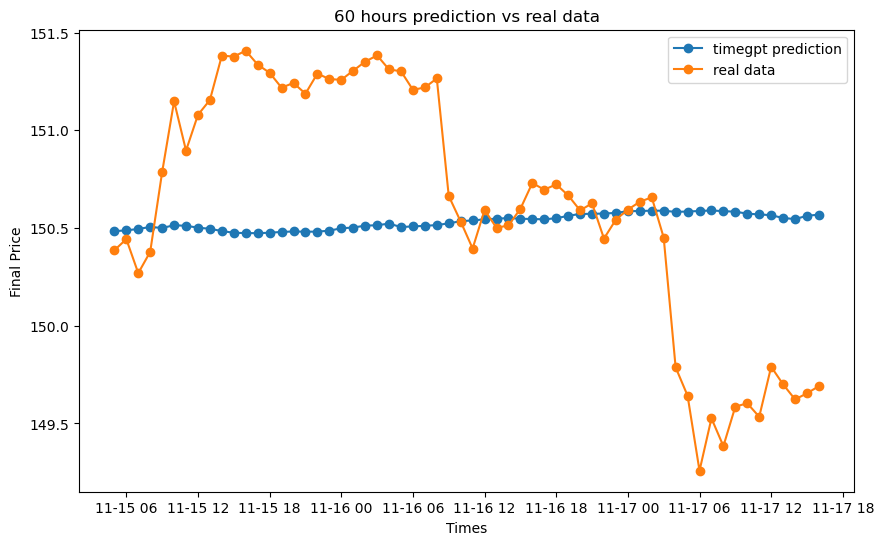

In [11]:
# 'Times'列を日時形式に変換
timegpt_pred_hour['Times'] = pd.to_datetime(timegpt_pred_hour['Times'])
USDJPY_test_hour.loc[:,'Times'] = pd.to_datetime(USDJPY_test_hour['Times'])

plt.figure(figsize=(10, 6))

# 予測値
plt.plot(timegpt_pred_hour['Times'], timegpt_pred_hour['TimeGPT'], label='timegpt prediction', marker='o')

#　真の値
plt.plot(USDJPY_test_hour['Times'], USDJPY_test_hour['Final Price'], label='real data', marker='o')

# ラベルとタイトルを追加
plt.xlabel('Times')
plt.ylabel('Final Price')
plt.title('60 hours prediction vs real data')
plt.legend()

plt.show()

In [12]:
# 予測値に基ついてリターンとラベルを計算
USDJPY_test_hour['1h_Return_real'] = np.log(USDJPY_test_hour['Final Price'] / USDJPY_test_hour['Final Price'].shift(1))
USDJPY_test_hour['1h_Return_real'] = USDJPY_test_hour['1h_Return_real'].fillna(0)

USDJPY_test_hour['Label_real'] = np.where(USDJPY_test_hour['1h_Return_real'] >= 0, 1, 0)

timegpt_pred_hour['1h_Return_pred'] = np.log(timegpt_pred_hour['TimeGPT'] / timegpt_pred_hour['TimeGPT'].shift(1))
timegpt_pred_hour['1h_Return_pred'] = timegpt_pred_hour['1h_Return_pred'].fillna(0)

timegpt_pred_hour['Label_pred'] = np.where(timegpt_pred_hour['1h_Return_pred'] >= 0, 1, 0)

display(USDJPY_test_hour)

/tmp/ipykernel_45822/1770162075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USDJPY_test_hour['1h_Return_real'] = np.log(USDJPY_test_hour['Final Price'] / USDJPY_test_hour['Final Price'].shift(1))
/tmp/ipykernel_45822/1770162075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USDJPY_test_hour['1h_Return_real'] = USDJPY_test_hour['1h_Return_real'].fillna(0)
/tmp/ipykernel_45822/1770162075.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,Times,Final Price,1h_Return_real,Label_real
0,2023-11-15 05:00:00,150.386,0.000000,1
1,2023-11-15 06:00:00,150.443,0.000379,1
2,2023-11-15 07:00:00,150.269,-0.001157,0
3,2023-11-15 08:00:00,150.378,0.000725,1
4,2023-11-15 09:00:00,150.786,0.002709,1
5,2023-11-15 10:00:00,151.148,0.002398,1
6,2023-11-15 11:00:00,150.896,-0.001669,0
7,2023-11-15 12:00:00,151.079,0.001212,1
8,2023-11-15 13:00:00,151.155,0.000503,1
9,2023-11-15 14:00:00,151.382,0.001501,1


### リターンの予測値と真の値のグラフ

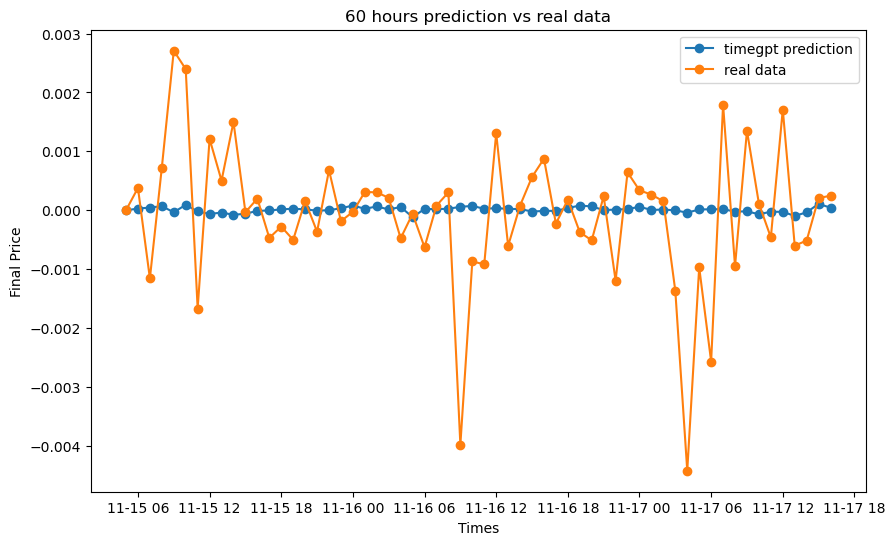

In [13]:
# 'Times'列を日時形式に変換
timegpt_pred_hour['Times'] = pd.to_datetime(timegpt_pred_hour['Times'])
USDJPY_test_hour.loc[:,'Times'] = pd.to_datetime(USDJPY_test_hour['Times'])

plt.figure(figsize=(10, 6))

# 予測値
plt.plot(timegpt_pred_hour['Times'], timegpt_pred_hour['1h_Return_pred'], label='timegpt prediction', marker='o')

# 真の値
plt.plot(USDJPY_test_hour['Times'], USDJPY_test_hour['1h_Return_real'], label='real data', marker='o')

# タイトルを追加する
plt.xlabel('Times')
plt.ylabel('Final Price')
plt.title('60 hours prediction vs real data')
plt.legend()

plt.show()

### モデルの予測を評価する

In [14]:
timegpt_pred_hour_subset = timegpt_pred_hour[['Times', '1h_Return_pred', 'Label_pred']]
USDJPY_test_hour_subset = USDJPY_test_hour[['1h_Return_real', 'Label_real']]

# 2つのDataFrameを結合する
df = pd.concat([timegpt_pred_hour_subset, USDJPY_test_hour_subset], axis=1)

display(df)

,Times,1h_Return_pred,Label_pred,1h_Return_real,Label_real
0,2023-11-15 05:00:00,0.000000e+00,1,0.000000,1
1,2023-11-15 06:00:00,2.828973e-05,1,0.000379,1
2,2023-11-15 07:00:00,4.664082e-05,1,-0.001157,0
3,2023-11-15 08:00:00,6.853777e-05,1,0.000725,1
4,2023-11-15 09:00:00,-3.365998e-05,0,0.002709,1
5,2023-11-15 10:00:00,9.185257e-05,1,0.002398,1
6,2023-11-15 11:00:00,-1.845094e-05,0,-0.001669,0
7,2023-11-15 12:00:00,-6.366850e-05,0,0.001212,1
8,2023-11-15 13:00:00,-3.802054e-05,0,0.000503,1
9,2023-11-15 14:00:00,-7.746500e-05,0,0.001501,1


In [17]:
# 予測を評価する
y_true = df['Label_real']
y_pred = df['Label_pred']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
precision_values, recall_values, _ = precision_recall_curve(y_true, y_pred)
aupr = auc(recall_values, precision_values)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {roc_auc:.4f}')
print(f'AUPR: {aupr:.4f}')

Accuracy: 0.5667
Precision: 0.5789
Recall: 0.6875
AUC: 0.5580
AUPR: 0.7166


## 将来1分毎の最終価格を予測する

In [18]:
USDJPY.set_index('Times', inplace=True)

start_date = '2023-09-17 00:00:00'
end_date = '2023-11-17 15:00:00'

USDJPY_pred_minute = USDJPY.loc[start_date:end_date]

USDJPY.reset_index(inplace=True)
USDJPY_pred_minute.reset_index(inplace=True)

display(USDJPY_pred_minute)

,Times,Final Price
0,2023-09-17 00:00:00,147.725336
1,2023-09-17 00:01:00,147.725286
2,2023-09-17 00:02:00,147.725236
3,2023-09-17 00:03:00,147.725185
4,2023-09-17 00:04:00,147.725135
...,...,...
88736,2023-11-17 14:56:00,149.640000
88737,2023-11-17 14:57:00,149.654000
88738,2023-11-17 14:58:00,149.654000
88739,2023-11-17 14:59:00,149.645000


In [19]:
# テストデータを準備
USDJPY.set_index('Times', inplace=True)

start_date_test = '2023-11-17 15:01:00'
end_date_test = '2023-11-17 16:00:00'
USDJPY_test_minute = USDJPY.loc[start_date_test:end_date_test]

USDJPY.reset_index(inplace=True)
USDJPY_test_minute.reset_index(inplace=True)

display(USDJPY_test_minute)

,Times,Final Price
0,2023-11-17 15:01:00,149.667
1,2023-11-17 15:02:00,149.666
2,2023-11-17 15:03:00,149.667
3,2023-11-17 15:04:00,149.689
4,2023-11-17 15:05:00,149.680
5,2023-11-17 15:06:00,149.675
6,2023-11-17 15:07:00,149.679
7,2023-11-17 15:08:00,149.678
8,2023-11-17 15:09:00,149.679
9,2023-11-17 15:10:00,149.680


In [20]:
# TimeGPT予測
timegpt_pred_minute = timegpt.forecast(
    df=USDJPY_pred_minute, h=60, finetune_steps=300,
    time_col='Times', target_col='Final Price',
)


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: T
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


In [21]:
display(timegpt_pred_minute)

,Times,TimeGPT
0,2023-11-17 15:01:00,149.654922
1,2023-11-17 15:02:00,149.655151
2,2023-11-17 15:03:00,149.655548
3,2023-11-17 15:04:00,149.655426
4,2023-11-17 15:05:00,149.654190
5,2023-11-17 15:06:00,149.653961
6,2023-11-17 15:07:00,149.652161
7,2023-11-17 15:08:00,149.652328
8,2023-11-17 15:09:00,149.653870
9,2023-11-17 15:10:00,149.654205


### 最終価格の予測と真の値のグラフ

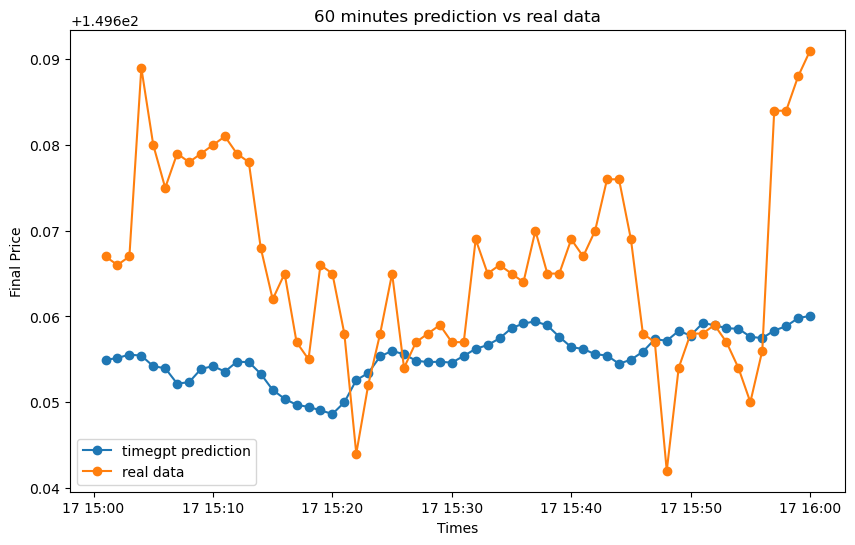

In [22]:
# 'Times'列を日時形式に変換
timegpt_pred_minute['Times'] = pd.to_datetime(timegpt_pred_minute['Times'])
USDJPY_test_minute.loc[:, 'Times'] = pd.to_datetime(USDJPY_test_minute['Times'])

plt.figure(figsize=(10, 6))

# 予測値
plt.plot(timegpt_pred_minute['Times'], timegpt_pred_minute['TimeGPT'], label='timegpt prediction', marker='o')

# 真の値
plt.plot(USDJPY_test_minute['Times'], USDJPY_test_minute['Final Price'], label='real data', marker='o')

# ラベルとタイトルを追加
plt.xlabel('Times')
plt.ylabel('Final Price')
plt.title('60分の予測 vs 実データ')
plt.legend()

plt.show()


In [23]:
USDJPY_test_minute['1m_Return_real'] = np.log(USDJPY_test_minute['Final Price'] / USDJPY_test_minute['Final Price'].shift(1))
USDJPY_test_minute['1m_Return_real'] = USDJPY_test_minute['1m_Return_real'].fillna(0)

USDJPY_test_minute['Label_real'] = np.where(USDJPY_test_minute['1m_Return_real'] >= 0, 1, 0)

timegpt_pred_minute['1m_Return_pred'] = np.log(timegpt_pred_minute['TimeGPT'] / timegpt_pred_minute['TimeGPT'].shift(1))
timegpt_pred_minute['1m_Return_pred'] = timegpt_pred_minute['1m_Return_pred'].fillna(0)

timegpt_pred_minute['Label_pred'] = np.where(timegpt_pred_minute['1m_Return_pred'] >= 0, 1, 0)

display(timegpt_pred_minute)

/tmp/ipykernel_45822/344857545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USDJPY_test_minute['1m_Return_real'] = np.log(USDJPY_test_minute['Final Price'] / USDJPY_test_minute['Final Price'].shift(1))
/tmp/ipykernel_45822/344857545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USDJPY_test_minute['1m_Return_real'] = USDJPY_test_minute['1m_Return_real'].fillna(0)
/tmp/ipykernel_45822/344857545.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,Times,TimeGPT,1m_Return_pred,Label_pred
0,2023-11-17 15:01:00,149.654922,0.000000e+00,1
1,2023-11-17 15:02:00,149.655151,1.529396e-06,1
2,2023-11-17 15:03:00,149.655548,2.650948e-06,1
3,2023-11-17 15:04:00,149.655426,-8.156755e-07,0
4,2023-11-17 15:05:00,149.654190,-8.258752e-06,0
5,2023-11-17 15:06:00,149.653961,-1.529406e-06,0
6,2023-11-17 15:07:00,149.652161,-1.203141e-05,0
7,2023-11-17 15:08:00,149.652328,1.121578e-06,1
8,2023-11-17 15:09:00,149.653870,1.029807e-05,1
9,2023-11-17 15:10:00,149.654205,2.243129e-06,1


### リターンの予測と真の値のグラフ

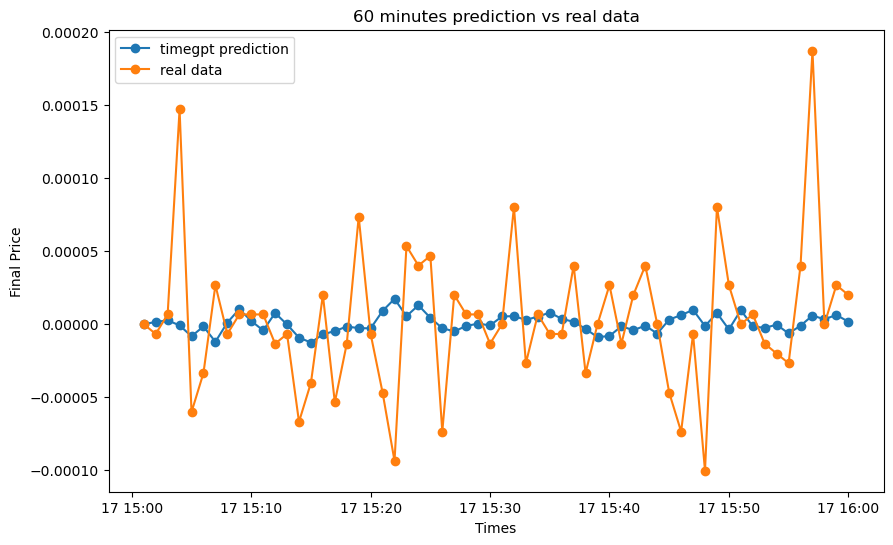

In [24]:
# 'Times'列を日時形式に変換
timegpt_pred_minute['Times'] = pd.to_datetime(timegpt_pred_minute['Times'])
USDJPY_test_minute.loc[:,'Times'] = pd.to_datetime(USDJPY_test_minute['Times'])
plt.figure(figsize=(10, 6))

# 予測値
plt.plot(timegpt_pred_minute['Times'], timegpt_pred_minute['1m_Return_pred'], label='timegpt prediction', marker='o')

# 真の値
plt.plot(USDJPY_test_minute['Times'], USDJPY_test_minute['1m_Return_real'], label='real data', marker='o')

# ラベルとタイトルを追加
plt.xlabel('Times')
plt.ylabel('Final Price')
plt.title('60 minutes prediction vs real data')
plt.legend()

plt.show()

### モデルを評価する

In [25]:
timegpt_pred_minute_subset = timegpt_pred_minute[['Times', '1m_Return_pred', 'Label_pred']]

USDJPY_test_minute_subset = USDJPY_test_minute[['1m_Return_real', 'Label_real']]

df = pd.concat([timegpt_pred_minute_subset, USDJPY_test_minute_subset], axis=1)

display(df)

,Times,1m_Return_pred,Label_pred,1m_Return_real,Label_real
0,2023-11-17 15:01:00,0.000000e+00,1,0.000000,1
1,2023-11-17 15:02:00,1.529396e-06,1,-0.000007,0
2,2023-11-17 15:03:00,2.650948e-06,1,0.000007,1
3,2023-11-17 15:04:00,-8.156755e-07,0,0.000147,1
4,2023-11-17 15:05:00,-8.258752e-06,0,-0.000060,0
5,2023-11-17 15:06:00,-1.529406e-06,0,-0.000033,0
6,2023-11-17 15:07:00,-1.203141e-05,0,0.000027,1
7,2023-11-17 15:08:00,1.121578e-06,1,-0.000007,0
8,2023-11-17 15:09:00,1.029807e-05,1,0.000007,1
9,2023-11-17 15:10:00,2.243129e-06,1,0.000007,1


In [26]:
# モデル評価
y_true = df['Label_real']
y_pred = df['Label_pred']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
precision_values, recall_values, _ = precision_recall_curve(y_true, y_pred)
aupr = auc(recall_values, precision_values)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {roc_auc:.4f}')
print(f'AUPR: {aupr:.4f}')

Accuracy: 0.5667
Precision: 0.6207
Recall: 0.5455
AUC: 0.5690
AUPR: 0.7081


## 将来5分毎の最終価格を予測する

In [27]:
# USDJPY通貨ペアを読み込む
USDJPY = pd.read_csv('currency_pair/USDJPY.csv', sep=',')

# 'Times'列を日時形式に変換
USDJPY['Times'] = pd.to_datetime(USDJPY['Times'], format='%Y%m%d %H%M%S', errors='coerce')

# 'Times'列を基準に重複する行を削除
USDJPY = USDJPY.drop_duplicates(subset=['Times'])

# 欠損値を補間する
USDJPY.set_index('Times', inplace=True)  # 'Times'列をインデックスに設定
USDJPY = USDJPY.resample('1T').interpolate().reset_index()  # 1分ごとにサンプリングし、欠損値を補間して再インデックス化

# 分が5の倍数の時刻の行を抽出
USDJPY_5m = USDJPY[USDJPY['Times'].dt.minute % 5 == 0]

# インデックスを0から再設定
USDJPY_5m = USDJPY_5m.reset_index(drop=True)

# 結果を表示
display(USDJPY_5m)

,Times,Final Price
0,2018-01-01 17:05:00,112.620
1,2018-01-01 17:10:00,112.616
2,2018-01-01 17:15:00,112.641
3,2018-01-01 17:20:00,112.626
4,2018-01-01 17:25:00,112.613
...,...,...
618042,2023-11-17 16:35:00,149.689
618043,2023-11-17 16:40:00,149.658
618044,2023-11-17 16:45:00,149.646
618045,2023-11-17 16:50:00,149.644


In [28]:
USDJPY_5m.set_index('Times', inplace=True)

start_date = '2023-01-17 00:00:00'
end_date = '2023-11-17 11:00:00'

# fine-tuningと予測ためのデータ準備
USDJPY_pred_5m = USDJPY_5m.loc[start_date:end_date]

USDJPY.reset_index(inplace=True)
USDJPY_pred_5m.reset_index(inplace=True)

display(USDJPY_pred_5m)

,Times,Final Price
0,2023-01-17 00:00:00,128.663
1,2023-01-17 00:05:00,128.699
2,2023-01-17 00:10:00,128.678
3,2023-01-17 00:15:00,128.617
4,2023-01-17 00:20:00,128.639
...,...,...
87680,2023-11-17 10:40:00,149.610
87681,2023-11-17 10:45:00,149.611
87682,2023-11-17 10:50:00,149.594
87683,2023-11-17 10:55:00,149.587


In [29]:
# テストデータの準備
start_date_test = '2023-11-17 11:01:00'
end_date_test = '2023-11-17 16:00:00'
USDJPY_test_5m = USDJPY_5m.loc[start_date_test:end_date_test]

USDJPY.reset_index(inplace=True)
USDJPY_test_5m.reset_index(inplace=True)

display(USDJPY_test_5m)

,Times,Final Price
0,2023-11-17 11:05:00,149.598
1,2023-11-17 11:10:00,149.616
2,2023-11-17 11:15:00,149.588
3,2023-11-17 11:20:00,149.712
4,2023-11-17 11:25:00,149.758
5,2023-11-17 11:30:00,149.761
6,2023-11-17 11:35:00,149.804
7,2023-11-17 11:40:00,149.846
8,2023-11-17 11:45:00,149.813
9,2023-11-17 11:50:00,149.793


In [30]:
#　TimeGPTの予測
timegpt_pred_5m = timegpt.forecast(
    df=USDJPY_pred_5m, h=60, finetune_steps=300,
    time_col='Times', target_col='Final Price',
)


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: 5T
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


In [31]:
display(timegpt_pred_5m)

,Times,TimeGPT
0,2023-11-17 11:05:00,149.548279
1,2023-11-17 11:10:00,149.550415
2,2023-11-17 11:15:00,149.556442
3,2023-11-17 11:20:00,149.558365
4,2023-11-17 11:25:00,149.548096
5,2023-11-17 11:30:00,149.544342
6,2023-11-17 11:35:00,149.543762
7,2023-11-17 11:40:00,149.542465
8,2023-11-17 11:45:00,149.542160
9,2023-11-17 11:50:00,149.548141


### 最終価格の予測と真の値のグラフ

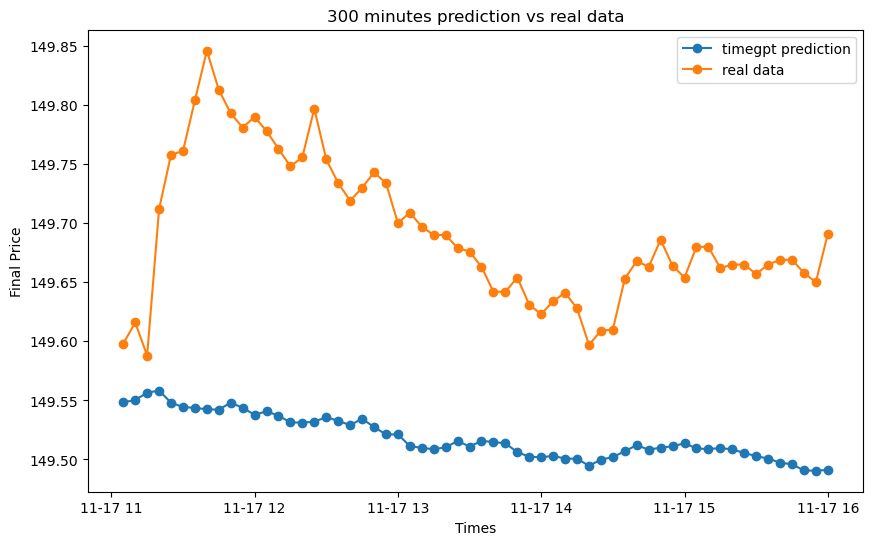

In [32]:
# 'Times'列を日時形式に変換
timegpt_pred_5m['Times'] = pd.to_datetime(timegpt_pred_5m['Times'])
timegpt_pred_5m.loc[:,'Times'] = pd.to_datetime(timegpt_pred_5m['Times'])

plt.figure(figsize=(10, 6))

# 予測値
plt.plot(timegpt_pred_5m['Times'], timegpt_pred_5m['TimeGPT'], label='timegpt prediction', marker='o')

# 真の値
plt.plot(USDJPY_test_5m['Times'], USDJPY_test_5m['Final Price'], label='real data', marker='o')

# ラベルとタイトルを追加
plt.xlabel('Times')
plt.ylabel('Final Price')
plt.title('300 minutes prediction vs real data')
plt.legend()

plt.show()

In [33]:
USDJPY_test_5m['5m_Return_real'] = np.log(USDJPY_test_5m['Final Price'] / USDJPY_test_5m['Final Price'].shift(5))
USDJPY_test_5m['5m_Return_real'] = USDJPY_test_5m['5m_Return_real'].fillna(0)

# ラベルを計算する
USDJPY_test_5m['Label_real'] = np.where(USDJPY_test_5m['5m_Return_real'] >= 0, 1, 0)

timegpt_pred_5m['5m_Return_pred'] = np.log(timegpt_pred_5m['TimeGPT'] / timegpt_pred_5m['TimeGPT'].shift(5))
timegpt_pred_5m['5m_Return_pred'] = timegpt_pred_5m['5m_Return_pred'].fillna(0)

timegpt_pred_5m['Label_pred'] = np.where(timegpt_pred_5m['5m_Return_pred'] >= 0, 1, 0)

display(timegpt_pred_5m)

/tmp/ipykernel_45822/1562956547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USDJPY_test_5m['5m_Return_real'] = np.log(USDJPY_test_5m['Final Price'] / USDJPY_test_5m['Final Price'].shift(5))
/tmp/ipykernel_45822/1562956547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USDJPY_test_5m['5m_Return_real'] = USDJPY_test_5m['5m_Return_real'].fillna(0)
/tmp/ipykernel_45822/1562956547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

,Times,TimeGPT,5m_Return_pred,Label_pred
0,2023-11-17 11:05:00,149.548279,0.000000e+00,1
1,2023-11-17 11:10:00,149.550415,0.000000e+00,1
2,2023-11-17 11:15:00,149.556442,0.000000e+00,1
3,2023-11-17 11:20:00,149.558365,0.000000e+00,1
4,2023-11-17 11:25:00,149.548096,0.000000e+00,1
5,2023-11-17 11:30:00,149.544342,-2.632474e-05,0
6,2023-11-17 11:35:00,149.543762,-4.448654e-05,0
7,2023-11-17 11:40:00,149.542465,-9.346106e-05,0
8,2023-11-17 11:45:00,149.542160,-1.083571e-04,0
9,2023-11-17 11:50:00,149.548141,3.060979e-07,1


### リターンの予測値と真の値のグラフ

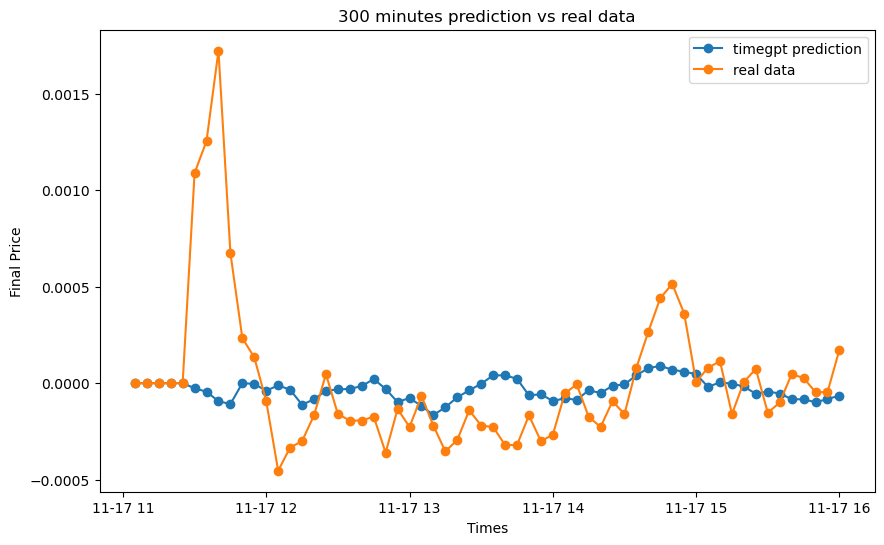

In [34]:
timegpt_pred_5m['Times'] = pd.to_datetime(timegpt_pred_5m['Times'])
USDJPY_test_5m.loc[:,'Times'] = pd.to_datetime(USDJPY_test_5m['Times'])

plt.figure(figsize=(10, 6))
plt.plot(timegpt_pred_5m['Times'], timegpt_pred_5m['5m_Return_pred'], label='timegpt prediction', marker='o')
plt.plot(USDJPY_test_5m['Times'], USDJPY_test_5m['5m_Return_real'], label='real data', marker='o')

plt.xlabel('Times')
plt.ylabel('Final Price')
plt.title('300 minutes prediction vs real data')
plt.legend()

plt.show()

### モデルを評価する

In [35]:
timegpt_pred_5m_subset = timegpt_pred_5m[['Times', '5m_Return_pred', 'Label_pred']]

USDJPY_test_5m_subset = USDJPY_test_5m[['5m_Return_real', 'Label_real']]
df = pd.concat([timegpt_pred_5m_subset, USDJPY_test_5m_subset], axis=1)

display(df)

,Times,5m_Return_pred,Label_pred,5m_Return_real,Label_real
0,2023-11-17 11:05:00,0.000000e+00,1,0.000000,1
1,2023-11-17 11:10:00,0.000000e+00,1,0.000000,1
2,2023-11-17 11:15:00,0.000000e+00,1,0.000000,1
3,2023-11-17 11:20:00,0.000000e+00,1,0.000000,1
4,2023-11-17 11:25:00,0.000000e+00,1,0.000000,1
5,2023-11-17 11:30:00,-2.632474e-05,0,0.001089,1
6,2023-11-17 11:35:00,-4.448654e-05,0,0.001256,1
7,2023-11-17 11:40:00,-9.346106e-05,0,0.001723,1
8,2023-11-17 11:45:00,-1.083571e-04,0,0.000674,1
9,2023-11-17 11:50:00,3.060979e-07,1,0.000234,1


In [36]:
# モデル予測を評価
y_true = df['Label_real']
y_pred = df['Label_pred']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
precision_values, recall_values, _ = precision_recall_curve(y_true, y_pred)
aupr = auc(recall_values, precision_values)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {roc_auc:.4f}')
print(f'AUPR: {aupr:.4f}')

Accuracy: 0.7333
Precision: 0.7647
Recall: 0.5200
AUC: 0.7029
AUPR: 0.7424
